#0. Importy

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !sudo pip install tensorflowjs
# !pip show tensorflow
# !pip show keras
# !python -V

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import tensorflowjs as tfjs

#1. Konfiguracja

In [5]:
SEED=123
np.random.seed(SEED)

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
base_path = "drive/MyDrive/ColabNotebooks/"
path_train_csv = "train.csv"
path_train_img = base_path + "datasets/train_undersampled"
checkpoint_path = base_path + "checkpoint2/"
models_path = base_path + '/models'

In [8]:
CONFIG = dict(
    # Preprocessing
    validation = 0.11,
    target_size = (224,224),
    input_shape = (224, 224, 3),

    # Training
    epochs = 20,
    verbose = 1,
    workers = 8,
    optimizer = 'adam', # 'SGD', 'RMSprop', 'adam'
    RANDOM_STATE = 123,
    loss = 'binary_crossentropy', # focal loss

    # Postprocessing
    label_smooth_fac  =  0.00,  # 0.01; 0.05; 0.1; 0.2;
)

#4. Przygotowanie zbiorów danych treningowych i testowych

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(path_train_img,
                                                    subset='training', 
                                                    target_size=CONFIG.get("target_size"),
                                                    batch_size = 16,
                                                    class_mode='categorical',
                                                    )

valid_generator = train_datagen.flow_from_directory(path_train_img,
                                                     subset='validation', 
                                                     target_size=CONFIG.get("target_size"),
                                                     batch_size = 16,
                                                     class_mode='categorical'
                                                     ) 

class_names = train_generator.class_indices
num_classes = len(class_names)
print('\n{} classes:\n{}'.format(num_classes,class_names))

Found 738 images belonging to 2 classes.
Found 314 images belonging to 2 classes.

2 classes:
{'benign': 0, 'malignant': 1}


In [10]:
from collections import Counter

counter_train = Counter(train_generator.classes)
ratio_train = round(counter_train.get(1) / counter_train.get(0), 3)
print("TRAINING >> {}, ratio malignant/benign: {}".format(counter_train.items(), ratio_train))

counter_valid = Counter(valid_generator.classes)
ratio_valid = round(counter_valid.get(1) / counter_valid.get(0), 3)
print("VALIDATION >> {}, ratio malignant/benign: {}".format(counter_valid.items(), ratio_valid))

TRAINING >> dict_items([(0, 369), (1, 369)]), ratio malignant/benign: 1.0
VALIDATION >> dict_items([(0, 157), (1, 157)]), ratio malignant/benign: 1.0


#6. Przygotowanie modelu

In [11]:
model_ResNet50 = tf.keras.Sequential([
     tf.keras.applications.ResNet50(
        input_shape = CONFIG.get("input_shape"),
        weights = 'imagenet', # one of None (random initialization), 
                              # 'imagenet' (pre-training on ImageNet) - default,
                              # or the path to the weights file to be loaded
        include_top = False # include the fully-connected layer at the top of the network
    ),
    
    GlobalAveragePooling2D(),
    
    Dense(num_classes, activation='softmax')
])

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
    
model_ResNet50.compile(
    optimizer = CONFIG.get("optimizer"),
    loss = CONFIG.get('loss'),
    metrics = METRICS
)

model_ResNet50.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
model_ResNet50.layers[0].trainable = False
model_ResNet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


#7. Trenowanie modelu

In [13]:
# ref: https://keras.io/api/callbacks/early_stopping/
cb_early_stopper = EarlyStopping(monitor = 'loss', patience = 5)

# ref: https://keras.io/api/callbacks/model_checkpoint/
cb_checkpointer  = ModelCheckpoint(filepath = checkpoint_path+'ResNet50-{epoch:02d}.hdf5',
                                   monitor = 'loss', 
                                   verbose = 1,
                                   save_best_only = True,
                                   mode = 'min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

In [14]:
history = model_ResNet50.fit(train_generator, 
                             epochs = CONFIG.get("epochs"), 
                             workers = CONFIG.get("workers"),
                             validation_data = valid_generator,
                             callbacks = callbacks_list 
                            )

Epoch 1/20
47/47 [==============================] - ETA: 0s - loss: 0.8275 - tp: 489.0000 - fp: 249.0000 - tn: 489.0000 - fn: 249.0000 - accuracy: 0.6626 - precision: 0.6626 - recall: 0.6626 - auc: 0.7146 - prc: 0.6984 
Epoch 1: loss improved from inf to 0.82747, saving model to drive/MyDrive/ColabNotebooks/checkpoint2/ResNet50-01.hdf5
47/47 [==============================] - 733s 15s/step - loss: 0.8275 - tp: 489.0000 - fp: 249.0000 - tn: 489.0000 - fn: 249.0000 - accuracy: 0.6626 - precision: 0.6626 - recall: 0.6626 - auc: 0.7146 - prc: 0.6984 - val_loss: 883.7233 - val_tp: 157.0000 - val_fp: 157.0000 - val_tn: 157.0000 - val_fn: 157.0000 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5000 - val_prc: 0.5000
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 0.5947 - tp: 546.0000 - fp: 192.0000 - tn: 546.0000 - fn: 192.0000 - accuracy: 0.7398 - precision: 0.7398 - recall: 0.7398 - auc: 0.8005 - prc: 0.7861 
Epoch 2: loss improved from

#8. Ocena modelu

In [15]:
history.history

{'loss': [0.827471137046814,
  0.5947255492210388,
  0.5049996972084045,
  0.5209726691246033,
  0.4781116545200348,
  0.4612278342247009,
  0.4478422701358795,
  0.44815802574157715,
  0.39203500747680664,
  0.395746111869812,
  0.3682158291339874,
  0.37362200021743774,
  0.395988404750824,
  0.3527696132659912,
  0.32205572724342346,
  0.3091983199119568,
  0.2732328176498413,
  0.25451546907424927,
  0.327027827501297,
  0.19417844712734222],
 'tp': [489.0,
  546.0,
  541.0,
  553.0,
  575.0,
  568.0,
  580.0,
  586.0,
  606.0,
  600.0,
  615.0,
  615.0,
  604.0,
  620.0,
  643.0,
  635.0,
  643.0,
  668.0,
  639.0,
  682.0],
 'fp': [249.0,
  192.0,
  197.0,
  185.0,
  163.0,
  170.0,
  158.0,
  152.0,
  132.0,
  138.0,
  123.0,
  123.0,
  134.0,
  118.0,
  95.0,
  103.0,
  95.0,
  70.0,
  99.0,
  56.0],
 'tn': [489.0,
  546.0,
  541.0,
  553.0,
  575.0,
  568.0,
  580.0,
  586.0,
  606.0,
  600.0,
  615.0,
  615.0,
  604.0,
  620.0,
  643.0,
  635.0,
  643.0,
  668.0,
  639.0,
  6

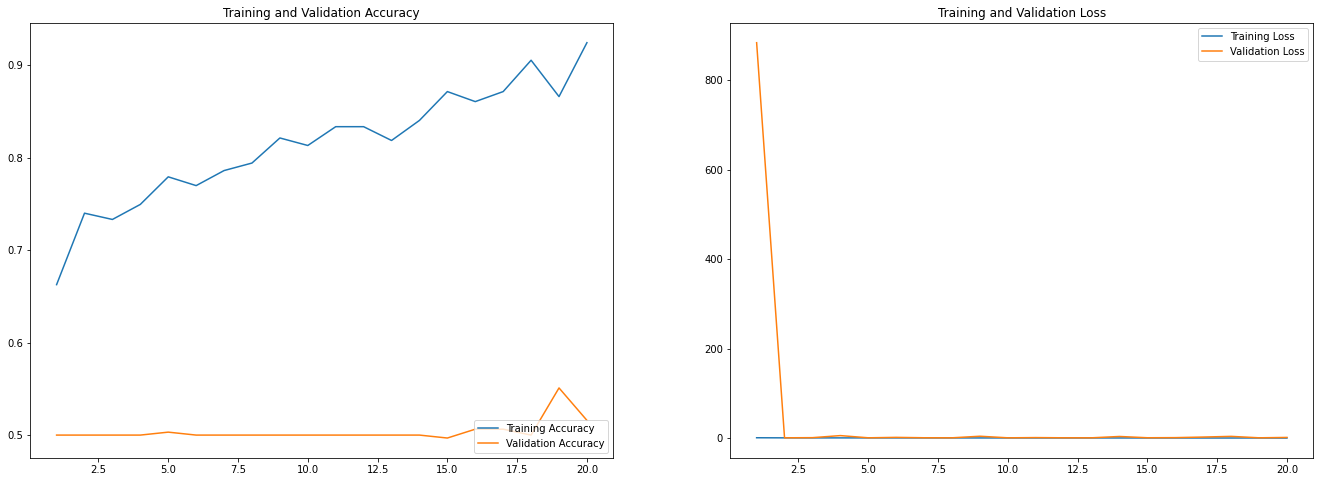

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()